In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [2]:
def unpack(compressed):
  ''' given a bit encoded voxel grid, make a normal voxel grid out of it.  '''
  uncompressed = np.zeros(compressed.shape[0] * 8, dtype=np.uint8)
  uncompressed[::8] = compressed[:] >> 7 & 1
  uncompressed[1::8] = compressed[:] >> 6 & 1
  uncompressed[2::8] = compressed[:] >> 5 & 1
  uncompressed[3::8] = compressed[:] >> 4 & 1
  uncompressed[4::8] = compressed[:] >> 3 & 1
  uncompressed[5::8] = compressed[:] >> 2 & 1
  uncompressed[6::8] = compressed[:] >> 1 & 1
  uncompressed[7::8] = compressed[:] & 1

  return uncompressed

class KittiLoader(Dataset):
    def __init__(self, root_dir, mode='train', sequences=['00'], split_ratio=1.0, 
                 get_vox_lidar=False, get_vox_invalid=False, get_vox_occluded=False):
        self.root_dir = root_dir
        self.mode = mode
        self.sequences = sequences
        self.image_names = []
        self.image2_dir = {}
        self.image3_dir = {}
        self.voxels_dir = {}
        self.get_vox_lidar=get_vox_lidar
        self.get_vox_invalid=get_vox_invalid
        self.get_vox_occluded=get_vox_occluded
        
        self.scene_size = [51.2, 51.2, 6.4] #unit m, 51.2m = 256 * 0.2m
        self.vox_origin = [0, -25.6, -2]#unit m
        self.voxel_size = 0.2  #m

        for seq in self.sequences:
            self.image2_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'image_2')
            self.image3_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'image_3')
            self.voxels_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'voxels')
            seq_image_names = [f.split('.')[0] for f in os.listdir(self.image2_dir[seq]) if f.endswith('.png')]
            self.image_names.extend([(seq, img_name) for img_name in seq_image_names])
        
        split_idx = int(len(self.image_names) * split_ratio )
        
        if self.mode == 'train':
            self.image_names = self.image_names[:split_idx]
        else:
            self.image_names = self.image_names[split_idx:]
        
        # Define transformations for standardization and conversion to tensor
        self.transform = transforms.Compose([
            transforms.ToTensor()#,
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet mean
            #                      std=[0.229, 0.224, 0.225])  # Standard ImageNet std
        ])

        self.class_map = {
            0 : 0,     # "unlabeled"
            1 : 0,     # "outlier" mapped to "unlabeled" --------------------------mapped
            10: 1,     # "car"
            11: 1,     # "bicycle"
            13: 1,     # "bus" mapped to "other-vehicle" --------------------------mapped
            15: 1,     # "motorcycle"
            16: 1,     # "on-rails" mapped to "other-vehicle" ---------------------mapped
            18: 1,     # "truck"
            20: 1,     # "other-vehicle"
            30: 1,     # "person"
            31: 1,     # "bicyclist"
            32: 1,     # "motorcyclist"
            40: 3,     # "road"
            44: 2,    # "parking"
            48: 4,    # "sidewalk"
            49: 4,    # "other-ground"
            50: 2,    # "building"
            51: 2,    # "fence"
            52: 2,     # "other-structure" mapped to "unlabeled" ------------------mapped ####
            60: 3,     # "lane-marking" to "road" ---------------------------------mapped
            70: 5,    # "vegetation"
            71: 5,    # "trunk"
            72: 3,    # "terrain"
            80: 2,    # "pole"
            81: 2,    # "traffic-sign"
            99: 1,     # "other-object" to "unlabeled" ----------------------------mapped ####
            252: 1,    # "moving-car" to "car" ------------------------------------mapped
            253: 1,    # "moving-bicyclist" to "bicyclist" ------------------------mapped
            254: 1,    # "moving-person" to "person" ------------------------------mapped
            255: 1,    # "moving-motorcyclist" to "motorcyclist" ------------------mapped
            256: 1,    # "moving-on-rails" mapped to "other-vehicle" --------------mapped
            257: 1,    # "moving-bus" mapped to "other-vehicle" -------------------mapped
            258: 1,    # "moving-truck" to "truck" --------------------------------mapped
            259: 1,    # "moving-other"-vehicle to "other-vehicle" ----------------mapped
        }
        
        self.class_names = [
            "empty", #0
            "obstacles", #1
            "building", #2
            "road", #3
            "sidewalk", #4
            "vegetation", #5
            "unknown", #6
        ]

        



    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq, img_name = self.image_names[idx]
        img2_name = os.path.join(self.image2_dir[seq], img_name + '.png')
        img3_name = os.path.join(self.image3_dir[seq], img_name + '.png')
        if self.get_vox_lidar:
            voxel_name = os.path.join(self.voxels_dir[seq], img_name + '.bin')
        label_name = os.path.join(self.voxels_dir[seq], img_name + '.label')
        if self.get_vox_invalid:
            invalid_name = os.path.join(self.voxels_dir[seq], img_name + '.invalid')
        if self.get_vox_occluded:
            occluded_name = os.path.join(self.voxels_dir[seq], img_name + '.occluded')
        
        
        # Load and transform images
        # from torchvision.transforms import ToTensor
        # img = ToTensor()(Image.open(img2_name).convert('RGB'))
        # print(img.max())
        left_image = self.transform(Image.open(img2_name).convert('RGB'))
        right_image = self.transform(Image.open(img3_name).convert('RGB'))

        extra_data = []
        # Load voxel data and convert to tensor
        if self.get_vox_lidar:
            voxel_data = torch.tensor(unpack(np.fromfile(voxel_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_data)
        #  0 invalid 1-19 class and 255 invalid
        voxel_labels = np.fromfile(label_name, dtype=np.uint16).reshape(256, 256, 32).astype(np.float32)
        voxel_labels = torch.tensor(np.vectorize(self.class_map.get)(voxel_labels))
        #print(voxel_data.shape)
        #print(voxel_labels.shape)
        
        if self.get_vox_occluded:
            voxel_occluded = torch.tensor(unpack(np.fromfile(occluded_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_occluded)
        
        if self.get_vox_invalid:
            voxel_invalid = torch.tensor(unpack(np.fromfile(invalid_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_invalid)
        
        
        
        if len(extra_data) != 0:
            return left_image, right_image, voxel_labels, tuple(extra_data)
        else:
            return left_image, right_image, voxel_labels
    
    
    def get_data(self, idx):
        return self.__getitem__(idx)

In [3]:
def voxel_to_coordinates(voxel_data, voxel_size=0.01, threshold = 0):
    xx, yy, zz = voxel_data.shape
    x_coords = []
    y_coords = []
    z_coords = []
    tags = []
    for x in range(xx):
        for y in range(yy):
            for z in range(zz):
                tag = voxel_data[x, y, z]
                if tag > threshold:
                    x_coords.append(x * voxel_size)
                    y_coords.append(y * voxel_size)
                    z_coords.append(z * voxel_size)
                    tags.append(tag)

    return np.array(x_coords), np.array(y_coords), np.array(z_coords), np.array(tags)

def visualize_labeled_array3d(voxel_data, num_classes=7, size = None, marker = None):
        voxel_data = voxel_data.astype(np.uint16)
        x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0])
        color_scale = bqplot.scales.ColorScale(min=0, max=num_classes, colors=["#f00", "#00f", "#000000", "#808080", "#0f0", "#800080"])
        fig = ipv.figure()
        unique_tags = np.unique(tags)

        for tag in unique_tags:
            mask = tags == tag
            x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
            
            ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.1, description="len({})={}".format(str(tag),x_filtered.shape[0]))
        ipv.xyzlabel('y','x','z')
        ipv.view(0, -50, distance=2.5)
        ipv.show()

def plot_tensor2d(img_tensor):
    tensor = img_tensor.permute(1, 2, 0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    plt.imshow(tensor)

In [4]:
sys.path.append("/workspace/HKU-OccNet/")
from utils.calib_utils import *
img_width, img_height = 1241, 376
calib = read_calib("/workspace/HKU-OccNet/calib.txt")
calib_proj = get_projections(img_width, img_height, calib)
train_set = KittiLoader(root_dir="/workspace/Dataset2/dataset", mode='train', 
                        sequences=['00', '01', '02'], 
                        get_vox_lidar=True, get_vox_invalid=True, get_vox_occluded=True)

vox_origin = torch.tensor([0, 128, 10])

vf_mask = calib_proj['fov_mask_1'].view(256, 256, 32)
prj_pix = calib_proj['projected_pix_1'].view(256, 256, 32, 2)
pix_z = calib_proj['pix_z_1'].view(256, 256, 32)

cull_mask = torch.zeros((256, 256, 32)).bool()
cull_mask[:int(0.5 * 256), :, :] = True

print(len(train_set))
print(len(train_set.class_names))


10303
7


In [5]:
def preprocess_gt(voxel_labels, voxel_invalid, mask = None):
    batch_size = voxel_labels.shape[0]
    v = voxel_labels.clone()
    v = v[:, int(0.1*256):int(0.6*256), 128-64:128+64, 0:16]
    vi = voxel_invalid[:, int(0.1*256):int(0.6*256), 128-64:128+64, 0:16]
    
    #print(v.shape)
    
    v[(vi > 0.5)] = 6
    #v[(v == 0) & (voxel_occluded > 0.5)] = 6
    
    if mask != None:
        mask = mask[int(0.1*256):int(0.6*256), 128-64:128+64, 0:16]
        mask = mask.unsqueeze(0).expand(batch_size, 128, 128, 16)
        v[~mask] = 0
        
    return v


import torch
from scipy import stats
import numpy as np
import torch.nn.functional as F

def majority_pooling_3d(tensor, kernel_size, stride=None, padding=0, exclude_zero=True):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size, kernel_size)
    if stride is None:
        stride = kernel_size
    elif isinstance(stride, int):
        stride = (stride, stride, stride)
    if isinstance(padding, int):
        padding = (padding, padding, padding)

    tensor = F.pad(tensor, (padding[2], padding[2], padding[1], padding[1], padding[0], padding[0]))

    output_shape = (
        (tensor.shape[0] - kernel_size[0]) // stride[0] + 1,
        (tensor.shape[1] - kernel_size[1]) // stride[1] + 1,
        (tensor.shape[2] - kernel_size[2]) // stride[2] + 1
    )

    output = torch.empty(output_shape, dtype=tensor.dtype)

    for i in range(output_shape[0]):
        for j in range(output_shape[1]):
            for k in range(output_shape[2]):
                start_i = i * stride[0]
                start_j = j * stride[1]
                start_k = k * stride[2]
                end_i = start_i + kernel_size[0]
                end_j = start_j + kernel_size[1]
                end_k = start_k + kernel_size[2]

                # Extract window
                window = tensor[start_i:end_i, start_j:end_j, start_k:end_k].flatten()

                

                # Filter out the target value
                if exclude_zero:
                    window = window[window != 0]
                    
                # # Compute majority (mode)
                #mode_value, _ = stats.mode(window.numpy().ravel(), axis=None)
                
                if len(window) > 0:
                    # Calculate the mode (most common element) in the neighborhood
                    counts = Counter(window.tolist())
                    mode_value = max(counts, key=counts.get)
                else:
                    mode_value = 0

                output[i, j, k] = torch.tensor(mode_value, dtype=tensor.dtype)

    return output

def majority_pooling_3d_batch(tensor, kernel_size, stride=None, padding=0, exclude_zero=True):
    """
    Perform majority pooling on a batch of 3D Tensors with padding.
    
    Args:
    tensor (torch.Tensor): The input tensor of shape (B, D, H, W).
    kernel_size (int or tuple): The size of the window to take a majority vote.
    stride (int or tuple, optional): The stride of the window. Default is same as kernel_size.
    padding (int or tuple, optional): The padding on each dimension. Default is 0.
    
    Returns:
    torch.Tensor: The majority pooled tensor.
    """
    batch_size = tensor.shape[0]

    # Apply majority pooling to each item in the batch
    pooled_batch = [majority_pooling_3d(tensor[b], kernel_size, stride, padding, exclude_zero) for b in range(batch_size)]
    
    # Stack the pooled results to get a batch tensor
    return torch.stack(pooled_batch)

import torch
from collections import Counter

def cast_label_to_majority_3d(tensor, target, kernel_size=3, exclude_zero=True):
    # Ensure the kernel size is odd to have a central element

    pad_size = kernel_size // 2
    # Padding for a 3D tensor requires 6 values (3 pairs for depth, height, width)
    padded_tensor = torch.nn.functional.pad(tensor, (pad_size, pad_size, pad_size, pad_size, pad_size, pad_size), mode='constant', value=target)

    # Iterate through each element in the original tensor
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            for k in range(tensor.shape[2]):
                if tensor[i, j, k] == target:
                    # Extract the neighboring elements based on the kernel size
                    neighborhood = padded_tensor[i:i+kernel_size, j:j+kernel_size, k:k+kernel_size].flatten()

                    # Filter out the target value
                    filtered_neighborhood = neighborhood[neighborhood != target]
                    
                    if exclude_zero:
                        filtered_neighborhood = filtered_neighborhood[filtered_neighborhood != 0]

                    if len(filtered_neighborhood) > 0:
                        # Calculate the mode (most common element) in the neighborhood
                        counts = Counter(filtered_neighborhood.tolist())
                        mode_value = max(counts, key=counts.get)
                        #print(mode_value)
                        tensor[i, j, k] = mode_value
                    else:
                        #print("debug")
                        pass
    return tensor

def cast_label_to_majority_3d_batch(tensor, target, kernel_size, exclude_zero=True):
    batch_size = tensor.shape[0]
    cast_batch = [cast_label_to_majority_3d(tensor[b], target, kernel_size, exclude_zero) for b in range(batch_size)]
    return torch.stack(cast_batch)


def preprocess_gt_pool(voxel_labels, voxel_invalid, vf_mask):
    voxel_pgt = preprocess_gt(voxel_labels, voxel_invalid, vf_mask)
    voxel_ppgt = majority_pooling_3d_batch(voxel_pgt, kernel_size=2, stride=2, padding=0)
    voxel_ppgt = cast_label_to_majority_3d_batch(voxel_ppgt, target=6, kernel_size=9)
    return voxel_ppgt

In [6]:
from utils import load_STTR_model
from utils import NestedTensor, batched_index_select

pretrained_weight_path = '/workspace/PretrainedWeights/kitti_finetuned_model.pth.tar'

class STTR_InputAdapterLayer(nn.Module):
    def __init__(self, downsample=3):
        super(STTR_InputAdapterLayer, self).__init__()
        self.downsample = downsample

    def forward(self, left_imgs, right_imgs):
        bs, _, h, w = left_imgs.shape  # Extract batch size, height, and width

        col_offset = int(self.downsample / 2)
        row_offset = int(self.downsample / 2)
        sampled_cols = torch.arange(col_offset, w, self.downsample)[None,].expand(bs, -1).cuda()
        sampled_rows = torch.arange(row_offset, h, self.downsample)[None,].expand(bs, -1).cuda()
        

        # Create NestedTensor for the batch
        nested_tensor = NestedTensor(left_imgs, right_imgs,  
                                    sampled_cols=sampled_cols, sampled_rows=sampled_rows)

        return nested_tensor

class STTR(nn.Module):
    def __init__(self, pretrained_weight_path, requires_grad = False):
        super(STTR, self).__init__()
        self.sttr_adapter_layer = STTR_InputAdapterLayer(downsample=3)
        self.sttr_pt = load_STTR_model(pretrained_weight_path)
        for param in self.sttr_pt.parameters():
            param.requires_grad = requires_grad
        
    def forward(self, left_img, right_img): 
        x = self.sttr_adapter_layer(left_img, right_img)

        bs, _, h, w = x.left.size()
        feat = self.sttr_pt.backbone(x)
        tokens = self.sttr_pt.tokenizer(feat)
        pos_enc = self.sttr_pt.pos_encoder(x)
        # separate left and right
        feat_left = tokens[:bs]
        feat_right = tokens[bs:]  # NxCxHxW
        # downsample
        if x.sampled_cols is not None:
            feat_left = batched_index_select(feat_left, 3, x.sampled_cols)
            feat_right = batched_index_select(feat_right, 3, x.sampled_cols)
        if x.sampled_rows is not None:
            feat_left = batched_index_select(feat_left, 2, x.sampled_rows)
            feat_right = batched_index_select(feat_right, 2, x.sampled_rows)
        attn_weight = self.sttr_pt.transformer(feat_left, feat_right, pos_enc)
        output = self.sttr_pt.regression_head(attn_weight, x)

        
        disp_map = output['disp_pred']
        occ_map = output['occ_pred'] > 0.5
        disp_map[occ_map] = 0.0
        
        return disp_map, feat_left, feat_right, attn_weight


sttr = STTR(pretrained_weight_path)
print("Number of parameters (in millions):", sum(p.numel() for p in sttr.parameters()) / 1_000_000, 'M')

Pre-trained model successfully loaded.
Number of parameters (in millions): 2.513811 M


In [7]:
# for name, module in sttr.sttr_pt.named_children():
#     print(name)

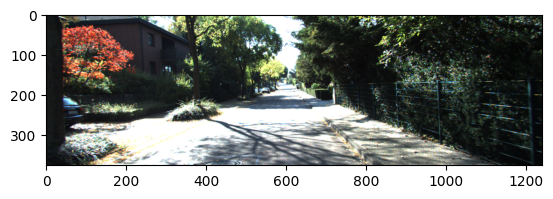

In [8]:
left_img, right_img, voxel_labels, extra_labels = train_set.__getitem__(random.randint(0, len(train_set)))
voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels

voxel_pgt = preprocess_gt_pool(voxel_labels.unsqueeze(0), voxel_invalid.unsqueeze(0), vf_mask)

plot_tensor2d(left_img)

In [9]:
# visualize_labeled_array3d((voxel_pgt.view(64, 64, 8)).cpu().numpy(), num_classes=len(train_set.class_names), 
#                                   size = 2, marker = 'box')

In [10]:
#sem_scal_loss, geo_scal_loss, CE_ssc_loss

def geo_scal_loss(pred, ssc_target, epsilon=1e-6):
    # Get softmax probabilities
    pred = F.softmax(pred, dim=1)

    # Check if prediction matches target exactly (pseudo-prediction case)
    if torch.all(pred.argmax(dim=1) == ssc_target):
        return torch.tensor(0.0).to(pred.device)

    # Compute empty and nonempty probabilities
    empty_probs = pred[:, 0, :, :, :]
    nonempty_probs = 1 - empty_probs

    # Remove unknown voxels (if necessary)
    mask = ssc_target != 255
    nonempty_target = ssc_target != 0
    nonempty_target = nonempty_target[mask].float()
    nonempty_probs = nonempty_probs[mask]
    empty_probs = empty_probs[mask]

    intersection = (nonempty_target * nonempty_probs).sum()
    precision = intersection / (nonempty_probs.sum() + epsilon)
    recall = intersection / (nonempty_target.sum() + epsilon)
    spec = ((1 - nonempty_target) * (empty_probs)).sum() / ((1 - nonempty_target).sum() + epsilon)

    return (
        F.binary_cross_entropy(precision, torch.ones_like(precision))
        + F.binary_cross_entropy(recall, torch.ones_like(recall))
        + F.binary_cross_entropy(spec, torch.ones_like(spec))
    )


def sem_scal_loss(pred, ssc_target, epsilon=1e-6):
    # Check for perfect match
    if torch.all(pred.argmax(dim=1) == ssc_target):
        return torch.tensor(0.0).to(pred.device)

    # Get softmax probabilities
    pred = F.softmax(pred, dim=1)
    loss = 0
    count = 0
    mask = ssc_target != 255
    n_classes = pred.shape[1]
    for i in range(n_classes):
        # Get probability of class i
        p = pred[:, i, :, :, :][mask]
        target = ssc_target[mask]

        completion_target = (target == i).float()

        if completion_target.sum() > 0:
            count += 1.0
            nominator = (p * completion_target).sum()

            # Precision
            precision = nominator / (p.sum() + epsilon)
            loss_precision = F.binary_cross_entropy(
                precision, torch.ones_like(precision)
            )

            # Recall
            recall = nominator / (completion_target.sum() + epsilon)
            loss_recall = F.binary_cross_entropy(recall, torch.ones_like(recall))

            # Specificity
            specificity = ((1 - p) * (1 - completion_target)).sum() / (
                (1 - completion_target).sum() + epsilon
            )
            loss_specificity = F.binary_cross_entropy(
                specificity, torch.ones_like(specificity)
            )

            loss_class = loss_precision + loss_recall + loss_specificity
            loss += loss_class

    return loss / max(count, epsilon)

def CE_ssc_loss(pred, target, class_weights):
    # Check for perfect match
    if torch.all(pred.argmax(dim=1) == target):
        return torch.tensor(0.0).to(pred.device)

    criterion = nn.CrossEntropyLoss(
        weight=class_weights, ignore_index=255, reduction="none"
    )
    loss = criterion(pred, target.long())
    loss_valid = loss[target != 255]
    return torch.mean(loss_valid)



def one_hot_encoding(labels, num_classes):
    # Assuming labels of shape [batch_size, depth, height, width]
    one_hot = F.one_hot(labels, num_classes)  # Convert to one-hot
    return one_hot.permute(0, 4, 1, 2, 3).float()

class_weights  = torch.tensor([
            0.3, #"empty", #0
            0.2, #"obstacles", #1
            0.1, #"building", #2
            0.2, #"road", #3
            0.1, #"sidewalk", #4
            0.09, #"vegetation", #5
            0.01 #"unknown", #6
        ])

    
v1h = one_hot_encoding(voxel_pgt, len(train_set.class_names))
print(v1h.shape)
print(geo_scal_loss(v1h, voxel_pgt))
print(sem_scal_loss(v1h, voxel_pgt))
print(CE_ssc_loss(v1h, voxel_pgt, class_weights))

torch.Size([1, 7, 64, 64, 8])
tensor(0.)
tensor(0.)
tensor(0.)


In [11]:
# sttr.eval()
# with torch.no_grad():
#     disp, feat_left, feat_right, attn_weight = sttr(left_img.unsqueeze(0).to(device), 
#                                                         right_img.unsqueeze(0).to(device))
    

In [12]:
# plot_tensor2d(disp.cpu())

In [13]:
# feat_left.shape

In [14]:
# attn_weight.shape

In [15]:
# left_img.shape

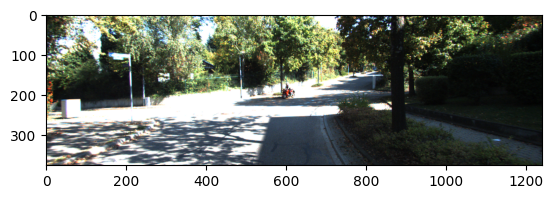

In [16]:
left_img, right_img, voxel_labels, extra_labels = train_set.__getitem__(random.randint(0, len(train_set)))
voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels

voxel_pgt = preprocess_gt_pool(voxel_labels.unsqueeze(0), voxel_invalid.unsqueeze(0), vf_mask)

plot_tensor2d(left_img)

In [17]:
# upsampled_logits = F.interpolate(outputs.logits, size=(376, 1241), mode='bilinear', align_corners=False)
# seg1h = torch.argmax(upsampled_logits, dim=1)
# seg1h.shape

In [18]:
# plot_tensor2d(seg1h)

In [19]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

class SegFormer(nn.Module):
    def __init__(self, requires_grad=False):
        super(SegFormer, self).__init__()
        
        self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
        self.segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
        for param in self.segformer.parameters():
            param.requires_grad = requires_grad
        
    def forward(self, img): 
        inputs = self.feature_extractor(images=img, return_tensors="pt", do_rescale=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        hidden_state = self.segformer.segformer(**inputs).last_hidden_state      
        logits = self.segformer(**inputs).logits
        logits = F.interpolate(logits, size=(376, 1241), mode='bilinear', align_corners=False)
        return logits, hidden_state
segformer = SegFormer()
print("Number of parameters (in millions):", sum(p.numel() for p in segformer.parameters()) / 1_000_000, 'M')

/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Number of parameters (in millions): 84.607955 M


In [20]:
# logit, hidden_state = segformer(left_img)

In [21]:
# logit.shape

In [22]:
# hidden_state.shape

In [23]:
# for name, module in seg_model.named_children():
#     print(name)

In [24]:
import torch.nn as nn

class Header(nn.Module):
    def __init__(self, input_channel, num_classes):
        super(Header, self).__init__()
        self.C = input_channel
        self.num_classes = num_classes
        
        # Upsample layer to double the spatial dimensions
        self.up_scale_2 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv3d(self.C, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU()
        )

        # Final convolutional layer to produce logits for each class
        self.final_conv = nn.Conv3d(128, self.num_classes, kernel_size=1)

    def forward(self, x):
        # x is expected to have the shape [B, C, 32, 32, 4]
        
        # Upscale to double the spatial dimensions: [B, C, 64, 64, 8]
        x = self.up_scale_2(x)

        # Pass through convolutional layers
        x = self.conv_layers(x)

        # Get num_classes for each voxel
        x = self.final_conv(x)

        # The output tensor shape will be [B, num_classes, 64, 64, 8]
        return x


In [25]:
header = Header(32, len(train_set.class_names))
from torchsummary import summary
summary(header, input_size=(32, 32, 32, 4), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1        [-1, 32, 64, 64, 8]               0
            Conv3d-2        [-1, 64, 64, 64, 8]          55,360
       BatchNorm3d-3        [-1, 64, 64, 64, 8]             128
              ReLU-4        [-1, 64, 64, 64, 8]               0
            Conv3d-5       [-1, 128, 64, 64, 8]         221,312
       BatchNorm3d-6       [-1, 128, 64, 64, 8]             256
              ReLU-7       [-1, 128, 64, 64, 8]               0
            Conv3d-8         [-1, 7, 64, 64, 8]             903
Total params: 277,959
Trainable params: 277,959
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 153.75
Params size (MB): 1.06
Estimated Total Size (MB): 155.31
----------------------------------------------------------------


In [26]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # Cross-Attention
        attn_output, _ = self.multihead_attn(query, key_value, key_value)
        # Add & Norm (Residual Connection and Layer Normalization)
        query = self.norm1(query + attn_output)
        return query

In [27]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math 
class Conv3D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1):
        super(Conv3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch_out),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x)
        return out

class ResNet3D_Block(nn.Module):
    def __init__(self, ch, k_size, stride=1, p=1):
        super(ResNet3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p), 
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x) + x
        return out

# class ConvUpSample3D_Block(nn.Module):
#     def __init__(self, ch_in, ch_out, k_size=1, scale=2, align_corners=False):
#         super(ConvUpSample3D_Block, self).__init__()
#         self.up = nn.Sequential(
#             nn.Conv3d(ch_in, ch_out, kernel_size=k_size),
#             nn.Upsample(scale_factor=scale, mode='trilinear', align_corners=align_corners),
#         )
#     def forward(self, x):
#         return self.up(x)

class Conv2D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1):
        super(Conv2D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=p),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        out = self.conv(x)
        return out

class ResNet2D_Block(nn.Module):
    def __init__(self, ch, k_size, stride=1, p=1):
        super(ResNet2D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size=k_size, stride=stride, padding=p),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(ch, ch, kernel_size=k_size, stride=stride, padding=p),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        out = self.conv(x) + x
        return out


In [39]:
class DepthSegLift_OCC(nn.Module):
    def __init__(self, num_classes, sttr, segformer):
        super(DepthSegLift_OCC, self).__init__()

        self.sttr = sttr
        self.seg = segformer

        ch_in = 26
        ch_out = 64
        self.ConvResBlock1 = nn.Sequential(
            Conv2D_Block(ch_in=ch_in, ch_out=ch_out, k_size=3),
            ResNet2D_Block(ch=ch_out, k_size=3),
            nn.MaxPool2d(3, stride=4, padding=1)
        )
        ch_in = 64
        ch_out = 128
        self.ConvResBlock2 = nn.Sequential(
            Conv2D_Block(ch_in=ch_in, ch_out=ch_out, k_size=3),
            ResNet2D_Block(ch=ch_out, k_size=3),
            nn.MaxPool2d(3, stride=4, padding=1)
        )
        ch_in = 128
        ch_out = 256
        self.ConvResBlock3 = nn.Sequential(
            Conv2D_Block(ch_in=ch_in, ch_out=ch_out, k_size=3),
            ResNet2D_Block(ch=ch_out, k_size=3),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.hs_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True)
        )

        self.relu = nn.LeakyReLU()
        self.linear1 = nn.Linear(512*12*39, 128)
        self.linear2 = nn.Linear(128, 32*32*32*4)
        
        self.header = Header(32, num_classes)
        
    def forward(self, left_img, right_img): 
        disp, feat_left, feat_right, attn_weight = self.sttr(left_img, right_img)
        logit, hidden_state = self.seg(left_img)
        x = torch.cat((disp.unsqueeze(1), logit, left_img, right_img), dim=1)
        x = self.ConvResBlock1(x)
        x = self.ConvResBlock2(x)
        x = self.ConvResBlock3(x)

        seg_hs = self.hs_conv(hidden_state)
        seg_hs = F.adaptive_avg_pool2d(seg_hs, (12, 39))
        x = torch.cat((x, seg_hs), dim=1)
        x = torch.flatten(x, start_dim=1)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = x.view(-1, 32, 32, 32, 4)
        logit = self.header(x)
        return logit
        
        
        
    
    def step(self, left_img, right_img, gt, class_weights):
        pred_1h = model(left_img, right_img)

        loss = sem_scal_loss(pred_1h, gt)
        loss += geo_scal_loss(pred_1h, gt)
        loss += CE_ssc_loss(pred_1h, gt, class_weights)
        return loss

In [40]:
# sttr = sttr.to(device)
# segformer = segformer.to(device)
# model = DepthSegLift_OCC(len(train_set.class_names), sttr, segformer)
# model = model.to(device)
# print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters()) / 1_000_000, 'M')
# pass

In [41]:
# 

In [42]:

# out = model(left_img.to(device).unsqueeze(0), right_img.to(device).unsqueeze(0))

In [43]:
from torch.utils.data import DataLoader, random_split
num_classes = len(train_set.class_names)



def rsplit(set, perc=0.7):
    split_idx = int(perc * len(set))
    return random_split(set, [split_idx, len(set) - split_idx])

train_set_small, _ = rsplit(train_set, 0.01)
train_subset, val_subset = rsplit(train_set_small, 0.85)

train_dataloader = DataLoader(train_subset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=1, shuffle=True)



print(len(train_dataloader))
print(len(val_dataloader))



87
16


In [44]:
sttr = sttr.to(device)
segformer = segformer.to(device)
model = DepthSegLift_OCC(len(train_set.class_names), sttr, segformer)
model = model.to(device)
print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters()) / 1_000_000, 'M')


Number of parameters (in millions): 137.046765 M


In [45]:
#model.load_state_dict(torch.load('dsocc.pth', map_location=device))

In [46]:
print(device)

cuda:0


In [47]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 5
best_loss = np.inf


In [61]:
from tqdm import tqdm
import torch.nn.functional as F



for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (left_img, right_img, voxel_labels, extra_labels) in tqdm(enumerate(train_dataloader),
                                                                     total = len(train_dataloader)):
        left_img = left_img.to(device)
        right_img = right_img.to(device)
        voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
        voxel_labels = voxel_labels.to(device)
        voxel_invalid = voxel_invalid.to(device)
        gt = preprocess_gt_pool(voxel_labels, voxel_invalid, (vf_mask).to(device))
        gt = gt.to(device)
        class_weights = class_weights.to(device)
        loss = model.step(left_img, right_img, gt, class_weights)
        
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20.0)
        
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for (left_img, right_img, voxel_labels, extra_labels) in tqdm(val_dataloader):
            left_img = left_img.to(device)
            right_img = right_img.to(device)
            voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
            voxel_labels = voxel_labels.to(device)
            voxel_invalid = voxel_invalid.to(device)
            gt = preprocess_gt_pool(voxel_labels, voxel_invalid, (vf_mask).to(device))
            gt = gt.to(device)
            class_weights = class_weights.to(device)
            loss = model.step(left_img, right_img, gt, class_weights)
            
            optimizer.zero_grad()
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'dsocc.pth')
        best_loss = (train_loss / len(train_dataloader))

100%|██████████| 16/16 [01:40<00:00,  6.26s/it]


Epoch 1: Training loss: 3.25775181562051, Validation loss: 3.8469289541244507


100%|██████████| 16/16 [01:38<00:00,  6.17s/it]


Epoch 2: Training loss: 3.0755636431704994, Validation loss: 3.7377700060606003


100%|██████████| 16/16 [03:13<00:00, 12.12s/it]


Epoch 3: Training loss: 2.913961457109999, Validation loss: 3.731700763106346


100%|██████████| 16/16 [05:14<00:00, 19.63s/it]


Epoch 4: Training loss: 2.6602943943834854, Validation loss: 3.7718720361590385


100%|██████████| 16/16 [05:16<00:00, 19.78s/it]


Epoch 5: Training loss: 2.486687987700276, Validation loss: 3.583250015974045


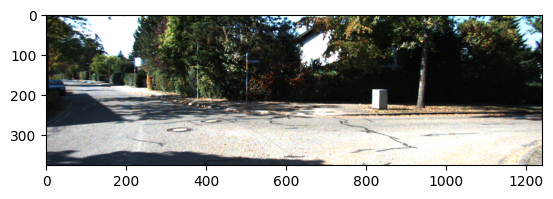

In [185]:
left_img, right_img, voxel_labels, extra_labels = train_subset.__getitem__(39) #random.randint(0, len(train_subset)-1)
voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
left_img = left_img.unsqueeze(0)
right_img = right_img.unsqueeze(0)
voxel_labels = voxel_labels.unsqueeze(0)
voxel_invalid = voxel_invalid.unsqueeze(0)
plot_tensor2d(left_img[0].cpu())

In [186]:
left_img = left_img.to(device)
right_img = right_img.to(device)
voxel_labels = voxel_labels.to(device)
voxel_invalid = voxel_invalid.to(device)
gt = preprocess_gt_pool(voxel_labels, voxel_invalid, (vf_mask).to(device))
gt = gt.to(device)

model.eval()
with torch.no_grad():
    pred_1h = model(left_img, right_img)

pred = torch.argmax(pred_1h, dim=1)



In [187]:
visualize_labeled_array3d((pred.view(64, 64, 8).float()).detach().cpu().numpy(), size = 2, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

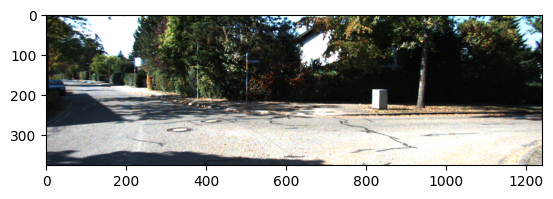

In [188]:
plot_tensor2d(left_img[0].cpu())